This notebook is part of the *orix* documentation https://orix.rtfd.io. Links to the documentation won’t work from the notebook.

# Clustering orientations

This notebook illustrates clustering of Ti crystal orientations using data
obtained from a highly deformed specimen, using EBSD, as presented in
<cite data-cite="johnstone2020density">Johnstone et al. (2020)</cite>. The data
is available here:
https://drive.google.com/drive/folders/1jJBWlOD3Q7klpEU3PvtSrp7Lmcn5o1af.

Import orix classes and various dependencies

In [1]:
# exchange inline for notebook (or qt5 from pyqt) for interactive plotting
%matplotlib inline

# Import core external
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Colorisation and visualisation
from matplotlib.colors import to_rgb
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.lines import Line2D
from skimage.color import label2rgb

# Import orix classes 
from orix.quaternion import Orientation, OrientationRegion, Rotation
from orix.quaternion.symmetry import D6
from orix.vector import AxAngle


plt.rcParams.update({"font.size": 20, "figure.figsize": (10, 10)})

## Import data

Load orientation mapping data specified in a standard CTF file as euler angles
in degrees, following the Bunge convention

In [2]:
file = "/home/hakon/kode/orix_test/Ti_orientations.ctf"
euler = np.loadtxt(file, skiprows=1, usecols=(0, 1, 2))

Create an orientation instance from the Euler angles, defined in
the MTEX convention as transformations from the crystal to the
sample reference frame

In [3]:
ori = Orientation.from_euler(np.radians(euler), convention="MTEX", symmetry=D6)
ori

Orientation (193167,) 622
[[ 0.3027 -0.0869  0.5083 -0.8015]
 [ 0.3088 -0.0868  0.5016 -0.8034]
 [ 0.3057 -0.0818  0.4995 -0.8065]
 ...
 [ 0.4925  0.1633  0.668  -0.5334]
 [ 0.4946  0.1592  0.6696 -0.5307]
 [ 0.4946  0.1592  0.6696 -0.5307]]

Reshape the orientation mapping data to the correct spatial dimension for the
scan

In [4]:
ori = ori.reshape(381, 507)

Select a subset of the orientations to reduce computation time

In [5]:
ori = ori[-100:, :200]

Set the point group symmetry *D6* (*622*) of Ti and map the
orientations into the fundamental zone (find symmetrically
equivalent orientations with the smallest angle of rotation)

In [6]:
ori.symmetry = D6
ori = ori.map_into_symmetry_reduced_zone()

## Compute distance matrix

In [7]:
# Increase the chunk size for a faster but more memory intensive computation
D = ori.get_distance_matrix(lazy=True, chunk_size=40)

[########################################] | 100% Completed |  1min  4.1s


In [8]:
D = D.reshape(ori.size, ori.size).data

## Clustering

For parameter explanations of the DBSCAN algorithm (Density-Based Spatial
Clustering for Applications with Noise), see the
[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

In [9]:
# This call will use about 6 GB of memory
dbscan = DBSCAN(
    eps=0.05,  # Max. distance between two samples in radians
    min_samples=40,
    metric="precomputed"
).fit(D)

unique_labels = np.unique(dbscan.labels_)
print("Labels:", unique_labels)

all_labels = dbscan.labels_.reshape(ori.shape)
n_clusters = unique_labels.size - 1
print("Number of clusters:", n_clusters)

Labels: [-1  0  1  2  3  4  5  6]
Number of clusters: 7


Calculate the mean orientation of each cluster

In [10]:
unique_cluster_labels = unique_labels[1:]  # Without the "no-cluster" label -1

q_mean = [ori[all_labels == l].mean() for l in unique_cluster_labels]
cluster_means = Orientation.stack(q_mean).flatten()

# Map into the fundamental zone
cluster_means.symmetry = D6
cluster_means = cluster_means.map_into_symmetry_reduced_zone()

cluster_means

Orientation (7,) 622
[[-0.7094 -0.1616  0.6682  0.1553]
 [ 0.8519  0.3835  0.3346 -0.1231]
 [ 0.8647  0.4319 -0.1888  0.1735]
 [ 0.8596  0.4059  0.2586 -0.1716]
 [ 0.785   0.2649  0.5591  0.0311]
 [ 0.7096  0.6541  0.2039  0.1642]
 [ 0.7942 -0.3078 -0.5239 -0.002 ]]

Inspect rotation axes in the axis-angle representation

In [11]:
cluster_means_axangle = AxAngle.from_rotation(cluster_means)
cluster_means_axangle.axis

Vector3d (7,)
[[ 0.2293 -0.9481 -0.2204]
 [ 0.7324  0.639  -0.2351]
 [ 0.8599 -0.3759  0.3454]
 [ 0.7944  0.5061 -0.3358]
 [ 0.4276  0.9026  0.0502]
 [ 0.9284  0.2895  0.2331]
 [-0.5065 -0.8622 -0.0033]]

Recenter data relative to the matrix cluster and recompute means

In [12]:
ori_recentered = (~cluster_means[0]) * ori

# Map into the fundamental zone
ori_recentered.symmetry = D6
ori_recentered = ori_recentered.map_into_symmetry_reduced_zone()

cluster_means_recentered = Orientation.stack(
    [ori_recentered[all_labels == l].mean() for l in unique_cluster_labels]
).flatten()

cluster_means_recentered

Orientation (7,) 1
[[ 1.      0.     -0.0002 -0.0001]
 [ 0.8463 -0.2653 -0.4618 -0.0001]
 [ 0.7824  0.3119  0.539  -0.0007]
 [ 0.7932 -0.3013 -0.5292  0.0058]
 [ 0.9674 -0.1234 -0.2212  0.0051]
 [ 0.8606 -0.4344 -0.2657  0.0034]
 [ 0.9544 -0.2864 -0.0372 -0.075 ]]

In [13]:
cluster_means_axangle = AxAngle.from_rotation(cluster_means_recentered)
cluster_means_axangle.axis

Vector3d (7,)
[[ 0.0306 -0.8117 -0.5832]
 [-0.4981 -0.8671 -0.0002]
 [ 0.5009  0.8655 -0.0012]
 [-0.4947 -0.869   0.0095]
 [-0.487  -0.8732  0.0199]
 [-0.853  -0.5218  0.0066]
 [-0.9598 -0.1248 -0.2514]]

## Visualisation

Specify colours and lines to identify each cluster

In [14]:
colors = [to_rgb(f"C{i}") for i in range(10)]
labels_rgb = label2rgb(all_labels, colors=colors, bg_label=-1)

lines = [((0, 0, 0), tuple(cm)) for cm in cluster_means_axangle.data]

Plot a top view of the orientation clusters within the fundamental zone for the
*D6* (*622*) point group symmetry of Ti

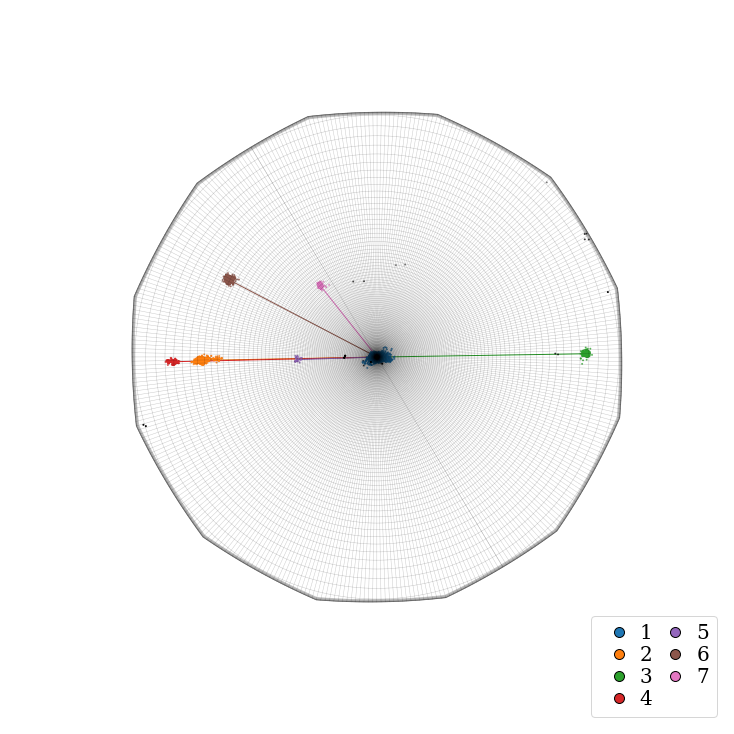

In [15]:
wireframe_kwargs = dict(color="black", linewidth=0.5, alpha=0.1, rcount=181, ccount=361)
fig = ori_recentered.scatter(
    projection="axangle",  # Default
    wireframe_kwargs=wireframe_kwargs,
    c=labels_rgb.reshape(-1, 3),
    s=1,
    return_figure=True
)
ax = fig.axes[0]
ax.view_init(elev=90, azim=-30)
ax.add_collection3d(Line3DCollection(lines, colors=colors))

handle_kwds = dict(marker="o", color="none", markersize=10)
handles = []
for i in range(n_clusters):
    line = Line2D([0], [0], label=i + 1, markerfacecolor=colors[i], **handle_kwds)
    handles.append(line)
ax.legend(
    handles=handles,
    loc="lower right",
    ncol=2,
    numpoints=1,
    labelspacing=0.15,
    columnspacing=0.15,
    handletextpad=0.05
);

Plot side view of orientation clusters

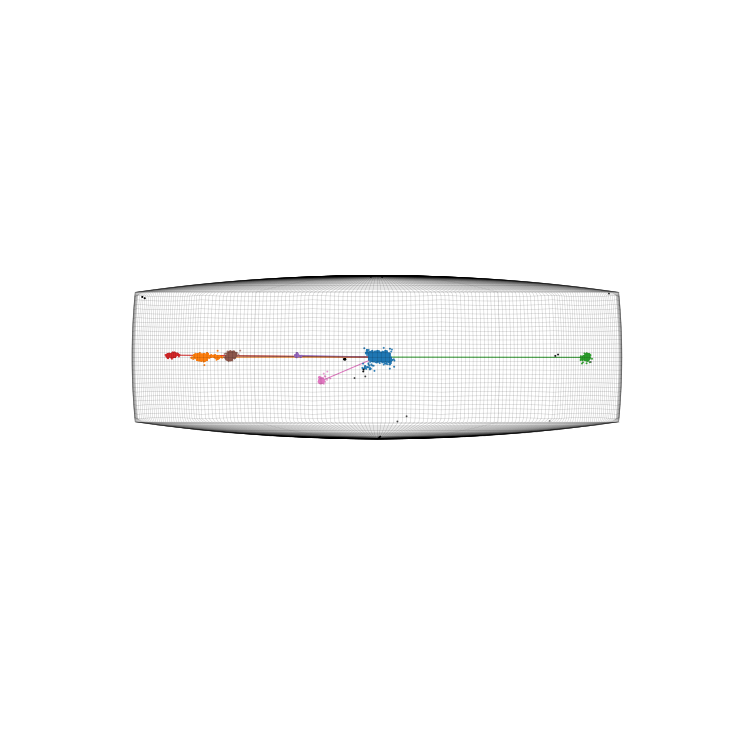

In [16]:
fig2 = ori_recentered.scatter(
    return_figure=True,
    wireframe_kwargs=wireframe_kwargs,
    c=labels_rgb.reshape(-1, 3),
    s=1,
)
ax2 = fig2.axes[0]
ax2.add_collection3d(Line3DCollection(lines, colors=colors))
ax2.view_init(elev=0, azim=-30)

Plot map indicating spatial locations associated with each cluster

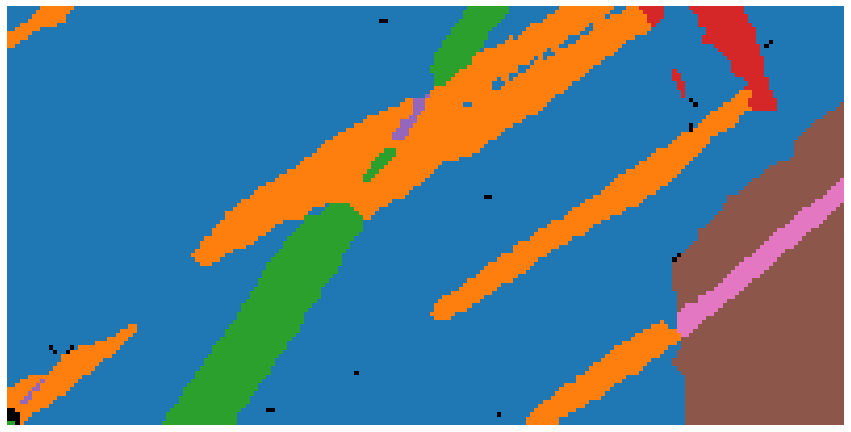

In [17]:
fig3 = plt.figure(figsize=(15, 10))
ax3 = fig3.add_subplot()
ax3.imshow(labels_rgb)
ax3.axis("off");